In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import datetime
from datetime import datetime

find consecutive at least 3 month price concessions

In [59]:
sql = """

WITH 
  price_concession AS (--subquery to remove duplicates due to different pack sizes
  SELECT
    ncso.date AS month, --month
    ncso.drug AS name,  -- drug name
    vmpp.bnf_code AS bnf_code, --BNF code from VMPP table
    ncso.price_pence AS pc_price_pence, --price concession cost per pack
    dt.price_pence AS dt_price_pence, --Drug Tariff cost per pack
    qtyval, --VMPP pack size
    (ncso.price_pence - dt.price_pence)/qtyval AS increased_ppu --difference between concession and usual Drug Tariff price
  FROM
    ebmdatalab.dmd.ncsoconcession AS ncso --concession table
  INNER JOIN
    dmd.vmpp_full AS vmpp --VMPP table
  ON
    ncso.vmpp = vmpp.id
  INNER JOIN
    dmd.tariffprice AS dt -- Drug Tariff table
  ON
    ncso.vmpp = dt.vmpp
    AND ncso.date = dt.date
  QUALIFY ROW_NUMBER() OVER (PARTITION BY ncso.date, vmpp.bnf_code ORDER BY (ncso.price_pence - dt.price_pence)/qtyval DESC) = 1 -- for each bnf_code and pack size, calculates PPU difference and ranks in order. Takes the top value, therefore only keeping the highest impact pack size, and thereby removes duplicates for pack size
  ORDER BY
    ncso.date,
    vmpp.bnf_code),
  rx_data AS (--subquery to create prescribing calculations)
  SELECT
    rx.month AS month,
    bnf_name,
    bnf_code AS bnf_code,
    SUM(quantity) AS quantity,
    SUM(net_cost) AS nic,
    SUM(actual_cost) AS actual_cost
  FROM
    ebmdatalab.hscic.normalised_prescribing AS rx
  GROUP BY
    rx.month,
    bnf_name,
    bnf_code)

#main query

SELECT
  ncso.month,
  rx.bnf_name,
  ncso.bnf_code,
  rx.quantity AS quantity,
  rx_old.quantity AS quantity_2_months_previously ,
  rx.nic,
  rx.actual_cost,
  ncso.dt_price_pence/(100*ncso.qtyval) AS normal_nic_per_unit, --calculates "normal" drug tariff price per unit,
  ncso.pc_price_pence/(100*ncso.qtyval) AS predicted_nic_per_unit, -- calculates price concession predicted cost per unit
FROM
  rx_data AS rx
INNER JOIN
  rx_data AS rx_old -- data from two months previously
ON
  rx.bnf_code = rx_old.bnf_code
  AND DATE(rx.month) = DATE_ADD(DATE(rx_old.month), INTERVAL 2 month) -- join to create data from two months ago
INNER JOIN
  price_concession AS ncso
ON
  COALESCE(DATE(rx.month),(DATE(rx_old.month)))  = ncso.month
  AND COALESCE(rx.bnf_code, rx_old.bnf_code) = ncso.bnf_code

ORDER BY
  rx.month
"""
exportfile = os.path.join("..","data","ncso_test_df.csv") #defines name for cache file
ncso_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
ncso_df['month'] = ncso_df['month'].astype('datetime64[ns]') #ensure dates are in datetimeformat
ncso_df['normal_nic_per_unit'] = ncso_df['normal_nic_per_unit'].astype(float) #ensure in float format
ncso_df['predicted_nic_per_unit'] = ncso_df['predicted_nic_per_unit'].astype(float) #ensure in float format
#ncso_df.set_index("month")



Downloading: 100%|██████████| 4504/4504 [00:00<00:00, 6613.92rows/s]


In [60]:
ncso_df.head()

,month,bnf_name,bnf_code,quantity,quantity_2_months_previously,nic,actual_cost,normal_nic_per_unit,predicted_nic_per_unit
0,2014-08-01,Hydrocortisone 10mg tablets,0603020J0AAADAD,1853682.0,1840292.0,3617621.72,3.349338e+06,1.715333,1.950667
1,2014-08-01,Valsartan 160mg capsules,0205052V0AAACAC,567160.0,561985.0,229171.56,2.123688e+05,0.088214,0.403571
2,2014-08-01,Co-amilofruse 2.5mg/20mg tablets,0202040B0AAABAB,454860.0,477859.0,70254.54,6.552452e+04,0.043571,0.154286
3,2014-08-01,Valsartan 40mg capsules,0205052V0AAAAAA,270796.0,329222.0,82208.67,7.622176e+04,0.057500,0.303571
4,2014-08-01,Naftidrofuryl 100mg capsules,0206040AEAAAAAA,811751.0,702411.0,183479.69,1.701659e+05,0.074643,0.226071


In [23]:
df2 = ncso_df.groupby(['month'])['bnf_code'].count().reset_index()

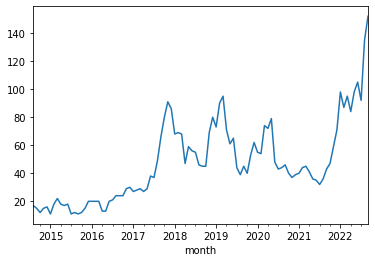

In [42]:
first_day_of_month = pd.to_datetime(datetime.today().date().replace(day=1))
ncso_df = ncso_df.loc[(ncso_df['month'] < first_day_of_month)]
ncso_df.groupby(['month'])['bnf_code'].count().plot()

In [44]:
ncso_df["excess_cost_pred"] = ncso_df["quantity_2_months_previously"] * (ncso_df["predicted_nic_per_unit"] - ncso_df["normal_nic_per_unit"])

In [45]:
ncso_df.head()

,month,bnf_name,bnf_code,quantity,quantity_2_months_previously,nic,actual_cost,normal_nic_per_unit,predicted_nic_per_unit,excess_cost_pred
0,2022-09-01,NaN,0501070N0AAABAB,NaN,NaN,NaN,NaN,21.430000,21.950000,NaN
1,2022-09-01,NaN,0304010G0AAAPAP,NaN,NaN,NaN,NaN,0.014733,0.020667,NaN
2,2022-09-01,NaN,0403040W0AAAAAA,NaN,NaN,NaN,NaN,0.030179,0.041250,NaN
4,2022-09-01,NaN,0403030P0AAAAAA,NaN,NaN,NaN,NaN,0.043000,0.063000,NaN
5,2022-09-01,NaN,0407010H0AAAQAQ,NaN,NaN,NaN,NaN,0.116300,0.145600,NaN


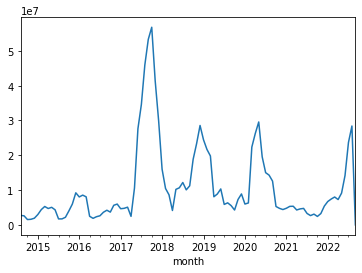

In [46]:
ncso_df.groupby(['month'])['excess_cost_pred'].sum().plot()

In [47]:
test_df = ncso_df.groupby(['month'])['excess_cost_pred'].sum()

In [50]:
test_df.head(2000)

month
2014-08-01    2.727639e+06
2014-09-01    2.617602e+06
2014-10-01    1.541373e+06
2014-11-01    1.617548e+06
2014-12-01    1.929368e+06
                  ...     
2022-05-01    9.139457e+06
2022-06-01    1.418908e+07
2022-07-01    2.370456e+07
2022-08-01    2.841592e+07
2022-09-01    0.000000e+00
Name: excess_cost_pred, Length: 98, dtype: float64

In [62]:
sql = """
SELECT
    ncso.date AS month, --month
    ncso.drug AS name,  -- drug name
    vmpp.bnf_code AS bnf_code, --BNF code from VMPP table
    ncso.price_pence AS pc_price_pence, --price concession cost per pack
    dt.price_pence AS dt_price_pence, --Drug Tariff cost per pack
    qtyval, --VMPP pack size
    (ncso.price_pence - dt.price_pence)/qtyval AS increased_ppu --difference between concession and usual Drug Tariff price
  FROM
    ebmdatalab.dmd.ncsoconcession AS ncso --concession table
  INNER JOIN
    dmd.vmpp_full AS vmpp --VMPP table
  ON
    ncso.vmpp = vmpp.id
  INNER JOIN
    dmd.tariffprice AS dt -- Drug Tariff table
  ON
    ncso.vmpp = dt.vmpp
    AND ncso.date = dt.date
  QUALIFY ROW_NUMBER() OVER (PARTITION BY ncso.date, vmpp.bnf_code ORDER BY (ncso.price_pence - dt.price_pence)/qtyval DESC) = 1 -- for each bnf_code and pack size, calculates PPU difference and ranks in order. Takes the top value, therefore only keeping the highest impact pack size, and thereby removes duplicates for pack size
  ORDER BY
    ncso.date,
    vmpp.bnf_code
"""
exportfile = os.path.join("..","data","price_df.csv") #defines name for cache file
price_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
price_df['month'] = price_df['month'].astype('datetime64[ns]') #ensure dates are in datetimeformat
price_df['increased_ppu'] = price_df['increased_ppu'].astype(float) #ensure in float formatincreased_ppu

In [63]:
price_df.head()

,month,name,bnf_code,pc_price_pence,dt_price_pence,qtyval,increased_ppu
0,2014-08-01,Amiloride 5mg tablets,0202030C0AAACAC,1950,806,28.0,40.857143
1,2014-08-01,Co-amilofruse 5/40 tablets,0202040B0AAAAAA,529,104,28.0,15.178571
2,2014-08-01,Co-amilofruse 2.5/20 tablets,0202040B0AAABAB,432,122,28.0,11.071429
3,2014-08-01,Co-Tenidone 50/12.5mg tablets,020400040AAAAAA,400,109,28.0,10.392857
4,2014-08-01,Co-Tenidone 100/25mg tablets,020400040AAABAB,400,123,28.0,9.892857


In [66]:
sql = """
WITH concession_list AS (
SELECT DISTINCT
    vmpp.bnf_code AS bnf_code --BNF code from VMPP table
  FROM
    ebmdatalab.dmd.ncsoconcession AS ncso --concession table
  INNER JOIN
    dmd.vmpp_full AS vmpp --VMPP table
  ON
    ncso.vmpp = vmpp.id
  INNER JOIN
    dmd.tariffprice AS dt -- Drug Tariff table
  ON
    ncso.vmpp = dt.vmpp
    AND ncso.date = dt.date
  QUALIFY ROW_NUMBER() OVER (PARTITION BY ncso.date, vmpp.bnf_code ORDER BY (ncso.price_pence - dt.price_pence)/qtyval DESC) = 1 -- for each bnf_code and pack size, calculates PPU difference and ranks in order. Takes the top value, therefore only keeping the highest impact pack size, and thereby removes duplicates for pack size)
)
SELECT
  rx.month,
  rx.bnf_name,
  rx.bnf_code,
  SUM(rx.quantity) AS quantity,
  SUM(rx.net_cost) AS nic,
  SUM(rx.actual_cost) AS actual_cost
  FROM hscic.normalised_prescribing as rx
INNER JOIN
  concession_list AS ncso
ON
rx.bnf_code = ncso.bnf_code
GROUP BY
rx.month, 
rx.bnf_name, 
rx.bnf_code
ORDER BY
  rx.month
  """
exportfile = os.path.join("..","data","rx_df.csv") #defines name for cache file
rx_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
rx_df['month'] = price_df['month'].astype('datetime64[ns]') #ensure dates are in datetimeformat


Downloading: 100%|██████████| 79800/79800 [00:10<00:00, 7962.91rows/s]


In [67]:
rx_df.head()

,month,bnf_name,bnf_code,quantity,nic,actual_cost
0,2014-08-01,Dihydrocodeine Tart_Tab 30mg,0407020G0AAACAC,12988388.0,652175.34,604194.31
1,2014-08-01,Ciprofloxacin_Tab 250mg,0501120L0AAAAAA,377769.0,39884.48,37285.92
2,2014-08-01,Esomeprazole_Tab E/C 40mg,0103050E0AAABAB,2023438.0,1820389.19,1676759.82
3,2014-08-01,Oxytetracycline_Tab 250mg,0501030T0AAAJAJ,6188804.0,285129.97,264136.27
4,2014-08-01,Amantadine HCl_Oral Soln 50mg/5ml S/F,0409010B0AAABAB,126314.0,6817.07,6281.83


In [73]:
#merged_left = pd.merge(left=price_df, right=rx_df, how='left', left_on=['month', 'bnf_code'], right_on=['month', 'bnf_code'])
merged_data= price_df.merge(rx_df,how='left', on=["month", "bnf_code"])


In [74]:
merged_data.head(500)

,month,name,bnf_code,pc_price_pence,dt_price_pence,qtyval,increased_ppu,bnf_name,quantity,nic,actual_cost
0,2014-08-01,Amiloride 5mg tablets,0202030C0AAACAC,1950,806,28.0,40.857143,NaN,NaN,NaN,NaN
1,2014-08-01,Co-amilofruse 5/40 tablets,0202040B0AAAAAA,529,104,28.0,15.178571,NaN,NaN,NaN,NaN
2,2014-08-01,Co-amilofruse 2.5/20 tablets,0202040B0AAABAB,432,122,28.0,11.071429,NaN,NaN,NaN,NaN
3,2014-08-01,Co-Tenidone 50/12.5mg tablets,020400040AAAAAA,400,109,28.0,10.392857,NaN,NaN,NaN,NaN
4,2014-08-01,Co-Tenidone 100/25mg tablets,020400040AAABAB,400,123,28.0,9.892857,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,2016-12-01,Lorazepam 1mg tablets,0401020P0AAABAB,605,235,28.0,13.214286,NaN,NaN,NaN,NaN
496,2016-12-01,Lorazepam 2.5mg tablets,0401020P0AAACAC,1250,295,28.0,34.107143,NaN,NaN,NaN,NaN
497,2016-12-01,Amitriptyline 50mg tablets,0403010B0AAAIAI,305,115,28.0,6.785714,NaN,NaN,NaN,NaN
498,2016-12-01,Mirtazapine 30mg tablets,0403040X0AAAAAA,155,124,28.0,1.107143,NaN,NaN,NaN,NaN


In [83]:
merged_data.head(500)
first_day_of_month = first_day_of_month = pd.to_datetime(datetime.today().date().replace(day=1))
test = merged_data.loc[(merged_data['month'] == first_day_of_month)]

In [84]:
test.head(500)

,month,name,bnf_code,pc_price_pence,dt_price_pence,qtyval,increased_ppu,bnf_name,quantity,nic,actual_cost
4658,2022-10-01,Mebeverine 135mg tablets,0102000P0AAABAB,390,329,100.0,0.610000,NaN,NaN,NaN,NaN
4659,2022-10-01,Rabeprazole 10mg gastro-resistant tablets,0103050T0AAAAAA,608,138,28.0,16.785714,NaN,NaN,NaN,NaN
4660,2022-10-01,Bisacodyl 5mg gastro-resistant tablets,0106020C0AAAAAA,499,278,60.0,3.683333,NaN,NaN,NaN,NaN
4661,2022-10-01,Nebivolol 5mg tablets,0204000ABAAAAAA,175,110,28.0,2.321429,Nebivolol_Tab 5mg,1169021.0,112037.90,104117.43
4662,2022-10-01,Nebivolol 2.5mg tablets,0204000ABAAABAB,1999,205,28.0,64.071429,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4747,2022-10-01,Latanoprost 50micrograms/ml eye drops,1106000L0AAAAAA,241,162,2.5,31.600000,Latanoprost_Eye Dps 50mcg/ml,501839.0,2753137.92,2538951.20
4748,2022-10-01,Dorzolamide 20mg/ml eye drops,1106000P0AAAAAA,432,325,5.0,21.400000,Dorzolamide_Eye Dps 2%,100980.0,119561.14,110446.08
4749,2022-10-01,Benzydamine 0.15% mouthwash sugar free,1203010E0AAAAAA,465,307,300.0,0.526667,NaN,NaN,NaN,NaN
4750,2022-10-01,Benzydamine 0.15% oromucosal spray sugar free,1203010E0AAABAB,380,335,30.0,1.500000,NaN,NaN,NaN,NaN


In [86]:
quantity_df = rx_df[['month','bnf_code','quantity']].copy()

In [87]:
quantity_df.head()

,month,bnf_code,quantity
0,2014-08-01,0407020G0AAACAC,12988388.0
1,2014-08-01,0501120L0AAAAAA,377769.0
2,2014-08-01,0103050E0AAABAB,2023438.0
3,2014-08-01,0501030T0AAAJAJ,6188804.0
4,2014-08-01,0409010B0AAABAB,126314.0


In [88]:
price_df.head()


,month,name,bnf_code,pc_price_pence,dt_price_pence,qtyval,increased_ppu
0,2014-08-01,Amiloride 5mg tablets,0202030C0AAACAC,1950,806,28.0,40.857143
1,2014-08-01,Co-amilofruse 5/40 tablets,0202040B0AAAAAA,529,104,28.0,15.178571
2,2014-08-01,Co-amilofruse 2.5/20 tablets,0202040B0AAABAB,432,122,28.0,11.071429
3,2014-08-01,Co-Tenidone 50/12.5mg tablets,020400040AAAAAA,400,109,28.0,10.392857
4,2014-08-01,Co-Tenidone 100/25mg tablets,020400040AAABAB,400,123,28.0,9.892857


In [89]:
merged_data= price_df.merge(quantity_df,how='outer', on=["month", "bnf_code"])

In [90]:
merged_data.head()

,month,name,bnf_code,pc_price_pence,dt_price_pence,qtyval,increased_ppu,quantity
0,2014-08-01,Amiloride 5mg tablets,0202030C0AAACAC,1950.0,806.0,28.0,40.857143,NaN
1,2014-08-01,Co-amilofruse 5/40 tablets,0202040B0AAAAAA,529.0,104.0,28.0,15.178571,NaN
2,2014-08-01,Co-amilofruse 2.5/20 tablets,0202040B0AAABAB,432.0,122.0,28.0,11.071429,NaN
3,2014-08-01,Co-Tenidone 50/12.5mg tablets,020400040AAAAAA,400.0,109.0,28.0,10.392857,NaN
4,2014-08-01,Co-Tenidone 100/25mg tablets,020400040AAABAB,400.0,123.0,28.0,9.892857,NaN


In [91]:
first_day_of_month = first_day_of_month = pd.to_datetime(datetime.today().date().replace(day=1))
test = merged_data.loc[(merged_data['month'] == first_day_of_month)]

In [92]:
test.head()

,month,name,bnf_code,pc_price_pence,dt_price_pence,qtyval,increased_ppu,quantity
4658,2022-10-01,Mebeverine 135mg tablets,0102000P0AAABAB,390.0,329.0,100.0,0.610000,NaN
4659,2022-10-01,Rabeprazole 10mg gastro-resistant tablets,0103050T0AAAAAA,608.0,138.0,28.0,16.785714,NaN
4660,2022-10-01,Bisacodyl 5mg gastro-resistant tablets,0106020C0AAAAAA,499.0,278.0,60.0,3.683333,NaN
4661,2022-10-01,Nebivolol 5mg tablets,0204000ABAAAAAA,175.0,110.0,28.0,2.321429,1169021.0
4662,2022-10-01,Nebivolol 2.5mg tablets,0204000ABAAABAB,1999.0,205.0,28.0,64.071429,NaN


In [93]:
#merged_data= price_df.merge(quantity_df,how='outer', on=["month", "bnf_code"])
df_merge_asof = pd.merge_asof(merged_data, quantity_df,
              on='month',
              by='bnf_code')

ValueError: Merge keys contain null values on left side